In [ ]:
!pip install aif360 'aif360[Reductions]' 'aif360[inFairness]'

In [ ]:
# ==============================
# Cell 1: Imports & Setup
# ==============================

# Display and visualization libraries
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Scikit-learn (ML)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

# AIF360 (Fairness)
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# ==============================
# Custom Styling Functions
# ==============================

# Color metrics depending on positive/negative values
def color_negative_positive(val):
    if isinstance(val, (int, float)):
        color = 'red' if val < 0 else 'green' if val > 0 else 'black'
        return f'color: {color}; font-weight: bold'
    return ''

# Highlight key fairness metrics
def highlight_metrics(s):
    metrics = [
        'Statistical Parity Difference',
        'Disparate Impact',
        'Equal Opportunity Difference',
        'Average Odds Difference'
    ]
    is_metric = s.index.isin(metrics)
    return ['background-color: #fffacd' if v else '' for v in is_metric]

# Format percentages consistently
def format_percent(x):
    return f"{float(x):.2%}"

# ==============================
# Visualization Setup
# ==============================
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Color palette (consistent across plots)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',
          '#d62728', '#9467bd', '#8c564b']


In [ ]:
# ==============================
# Cell 2: Load & Preprocess COMPAS Dataset
# ==============================
df_raw = pd.read_csv("compas-scores-raw.csv")

# Display dataset shape and first rows
display(HTML("<h3 style='color:#1f77b4;'>COMPAS Dataset: Raw Overview</h3>"))
print(f"Dataset shape: {df_raw.shape}")
display(df_raw.head())
# Keep only "Risk of Recidivism" assessments
df = df_raw[df_raw['DisplayText'] == "Risk of Recidivism"].copy()

# Map protected attribute: Race (1 = Caucasian, 0 = African-American, drop others)
df = df[df['Ethnic_Code_Text'].isin(['Caucasian', 'African-American'])]
df['race_binary'] = df['Ethnic_Code_Text'].apply(lambda x: 1 if x == 'Caucasian' else 0)

# Map gender for later analysis (not main protected attr here)
df['sex_binary'] = df['Sex_Code_Text'].apply(lambda x: 1 if x == 'Male' else 0)

# Define target variable: Risk score (1 = High/Medium risk, 0 = Low risk)
df['recidivism'] = df['ScoreText'].apply(lambda x: 1 if x in ['Medium', 'High'] else 0)

# Select modeling features
feature_cols = ['race_binary', 'sex_binary']
target_col = 'recidivism'

df_model = df[feature_cols + [target_col]].copy()

# ==============================
# Display Dataset Summary
# ==============================
summary_data = {
    'Description': [
        'Total samples',
        'Protected attribute',
        'Target variable',
        'Positive class (recidivism=1)',
        'Negative class (recidivism=0)'
    ],
    'Value': [
        len(df_model),
        'race (African-American vs Caucasian)',
        'Risk of Recidivism (ScoreText)',
        df_model['recidivism'].sum(),
        (df_model['recidivism'] == 0).sum()
    ]
}

summary_df = pd.DataFrame(summary_data)

display(HTML("<h3 style='color:#1f77b4;'>COMPAS Dataset Summary</h3>"))
display(summary_df.style
        .hide(axis="index")
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))


Dataset shape: (20137, 28)


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4.0,Low,New,1.0,0.0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2.0,Low,New,1.0,0.0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1.0,Low,New,1.0,0.0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2.0,Low,New,1.0,0.0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1.0,Low,New,1.0,0.0


Description,Value
Total samples,5451
Protected attribute,race (African-American vs Caucasian)
Target variable,Risk of Recidivism (ScoreText)
Positive class (recidivism=1),2672
Negative class (recidivism=0),2779


,Count,% of Total,% High/Medium Risk,Average DecileScore
race_binary,,,,
African-American,3061,56.15%,60.83%,5.47
Caucasian,2390,43.85%,33.89%,3.67


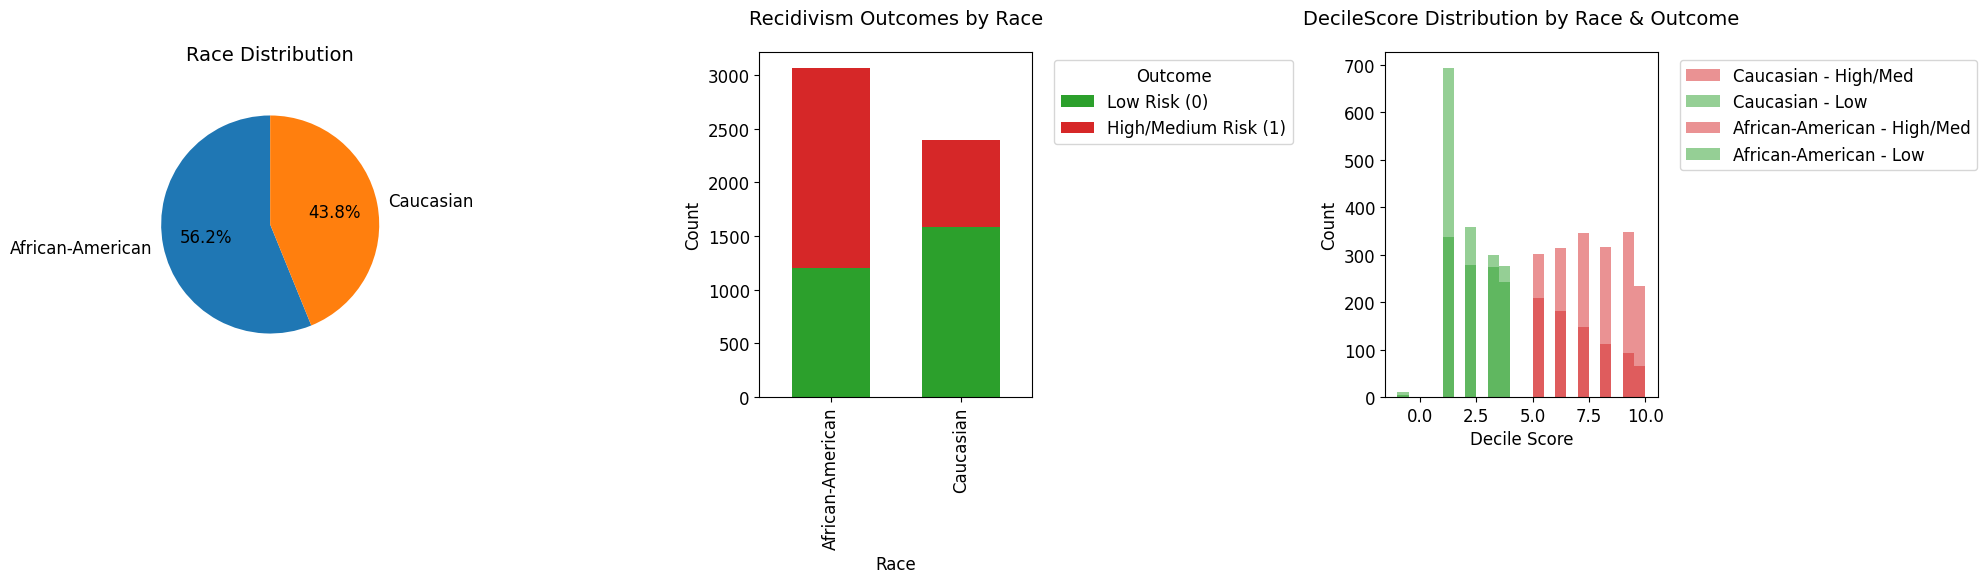

In [ ]:
# ==============================
# Cell 3: Demographic Breakdown & Visualizations
# ==============================

# Demographic breakdown by race
demo_stats = pd.DataFrame({
    'Count': df['race_binary'].value_counts(),
    '% of Total': df['race_binary'].value_counts(normalize=True) * 100,
    '% High/Medium Risk': df.groupby('race_binary')['recidivism'].apply(lambda x: (x.mean() * 100)),
    'Average DecileScore': df.groupby('race_binary')['DecileScore'].mean()
})

# Map race labels for readability
demo_stats.index = demo_stats.index.map({1: 'Caucasian', 0: 'African-American'})

# Display styled demographic table
display(HTML("<h3 style='color:#1f77b4;'>Detailed Demographic Breakdown (Race)</h3>"))
display(demo_stats.style.format({
    '% of Total': '{:.2f}%',
    '% High/Medium Risk': '{:.2f}%',
    'Average DecileScore': '{:.2f}'
}).background_gradient(cmap='Blues', subset=['Count'])
  .set_properties(**{'text-align': 'center'}))

# ==============================
# Visualizations
# ==============================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Pie chart: race distribution
race_counts = df['race_binary'].value_counts()
race_labels = race_counts.index.map({1: 'Caucasian', 0: 'African-American'})
ax1.pie(race_counts, labels=race_labels, autopct="%1.1f%%",
        colors=colors[:2], startangle=90, textprops={'fontsize': 12})
ax1.set_title('Race Distribution', fontsize=14, pad=20)

# Bar chart: recidivism outcomes by race
risk_by_race = pd.crosstab(df['race_binary'], df['recidivism'])
risk_by_race.index = risk_by_race.index.map({1: 'Caucasian', 0: 'African-American'})
risk_by_race.columns = ['Low Risk (0)', 'High/Medium Risk (1)']
risk_by_race.plot(kind="bar", stacked=True, ax=ax2,
                  color=['#2ca02c', '#d62728'], width=0.6)
ax2.set_title('Recidivism Outcomes by Race', fontsize=14, pad=20)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Race', fontsize=12)
ax2.legend(title="Outcome", bbox_to_anchor=(1.05, 1), loc='upper left')

# Histogram: DecileScore by race and recidivism
for race, race_label in [(1, 'Caucasian'), (0, 'African-American')]:
    for outcome, color in zip([1, 0], ['#d62728', '#2ca02c']):
        subset = df[(df['race_binary'] == race) & (df['recidivism'] == outcome)]
        ax3.hist(subset['DecileScore'], bins=10, alpha=0.5,
                 label=f"{race_label} - {'High/Med' if outcome==1 else 'Low'}",
                 color=color)
ax3.set_title('DecileScore Distribution by Race & Outcome', fontsize=14, pad=20)
ax3.set_xlabel('Decile Score', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# ==============================
# Cell 4: Train/Test Split Information
# ==============================

from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = df_model[feature_cols]
y = df_model[target_col]

# Split dataset (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Create DataFrames for train/test sizes
split_stats = pd.DataFrame({
    ' ': ['Count', 'Percentage'],
    'Training Set': [f"{X_train.shape[0]:,}", f"{X_train.shape[0]/len(df_model):.1%}"],
    'Test Set': [f"{X_test.shape[0]:,}", f"{X_test.shape[0]/len(df_model):.1%}"]
}).set_index(' ')

# Display styled split summary
display(HTML("<h3 style='color:#1f77b4;'>Dataset Split Information</h3>"))
display(split_stats.style
        .set_caption("Training vs Test Split")
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))


,Training Set,Test Set
,,
Count,"3,815","1,636"
Percentage,70.0%,30.0%


/tmp/ipython-input-2343998795.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Consistency': float(metric_train.consistency())


/tmp/ipython-input-2343998795.py:41: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_negative_positive)


,Value
Metric,
Statistical Parity Difference,-0.2649
Disparate Impact,0.5970
Mean Difference,-0.2649
Consistency,0.5281


/tmp/ipython-input-2343998795.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_to_plot, rotation=15, ha='right')


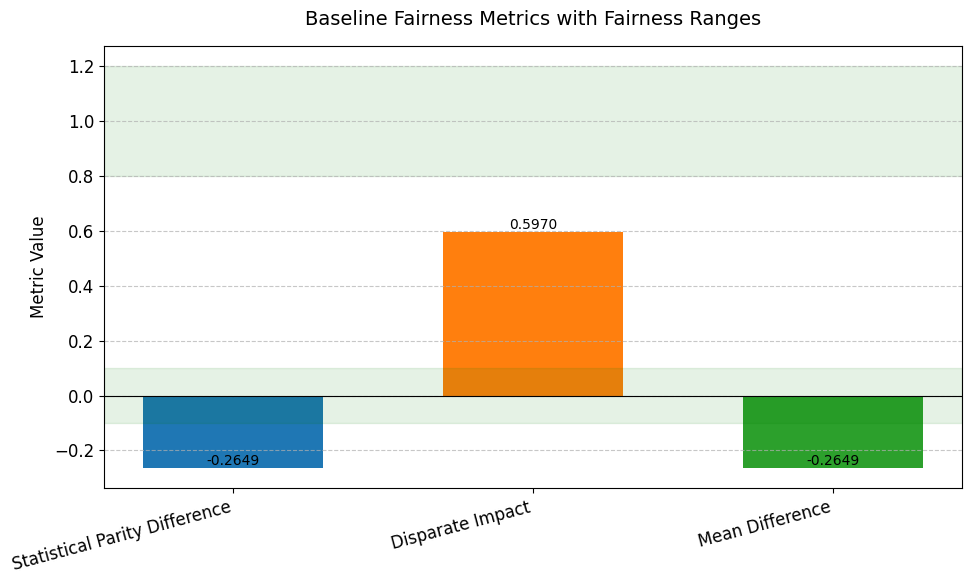

In [ ]:
# ==============================
# Cell 5: Baseline Fairness Metrics
# ==============================

from aif360.datasets import BinaryLabelDataset

# Convert training data into AIF360 BinaryLabelDataset
train_bld = BinaryLabelDataset(
    favorable_label=0,  # Low risk = favorable
    unfavorable_label=1,  # High/Medium risk = unfavorable
    df=pd.concat([X_train, y_train], axis=1),
    label_names=[target_col],
    protected_attribute_names=['race_binary']
)

# Define groups
privileged_groups = [{'race_binary': 1}]   # Caucasian
unprivileged_groups = [{'race_binary': 0}] # African-American

# Compute fairness metrics
metric_train = BinaryLabelDatasetMetric(
    train_bld,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

baseline_metrics = {
    'Statistical Parity Difference': float(metric_train.statistical_parity_difference()),
    'Disparate Impact': float(metric_train.disparate_impact()),
    'Mean Difference': float(metric_train.mean_difference()),
    'Consistency': float(metric_train.consistency())
}

# Display metrics table
metrics_df = pd.DataFrame.from_dict(baseline_metrics, orient="index", columns=['Value'])
metrics_df.index.name = 'Metric'

display(HTML("<h3 style='color:#1f77b4;'>Baseline Fairness Metrics</h3>"))
display(metrics_df.style
        .format("{:.4f}")
        .applymap(color_negative_positive)
        .apply(highlight_metrics)
        .set_caption("Comprehensive Baseline Fairness Metrics")
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

# ==============================
# Visualization: Bar chart of fairness metrics
# ==============================
fig, ax = plt.subplots(figsize=(10, 6))
metrics_to_plot = ['Statistical Parity Difference', 'Disparate Impact', 'Mean Difference']
values = [baseline_metrics[m] for m in metrics_to_plot]

bars = ax.bar(metrics_to_plot, values, color=colors[:3], width=0.6)

# Add reference lines
ax.axhline(0, color='black', linewidth=0.8)
ax.axhspan(-0.1, 0.1, alpha=0.1, color='green')  # Fair range for SPD & Mean Diff
ax.axhspan(0.8, 1.2, alpha=0.1, color='green')   # Fair range for Disparate Impact

# Annotate values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

ax.set_title("Baseline Fairness Metrics with Fairness Ranges", fontsize=14, pad=15)
ax.set_ylabel("Metric Value", fontsize=12)
ax.set_xticklabels(metrics_to_plot, rotation=15, ha='right')
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


,Statistic,Value
0,Minimum,0.7755
1,Maximum,1.4307
2,Mean,1.0000
3,Median,0.8068
4,Standard Deviation,0.2739
5,Q1 (25th percentile),0.7755
6,Q3 (75th percentile),1.2990


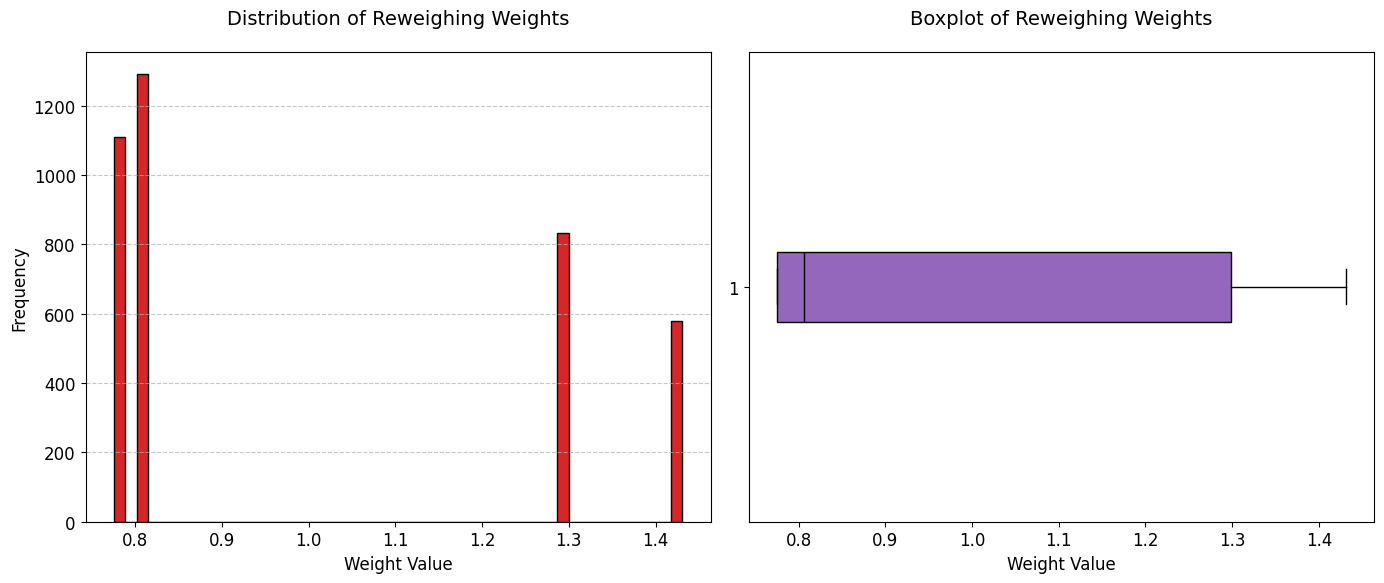

In [ ]:
# ==============================
# Cell 6: Apply Reweighing Mitigation
# ==============================

# Apply reweighing algorithm
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

train_bld_transf = RW.fit_transform(train_bld)

# Extract instance weights
weights = train_bld_transf.instance_weights

# Weight statistics
weight_stats = {
    'Statistic': ['Minimum', 'Maximum', 'Mean', 'Median', 'Standard Deviation',
                  'Q1 (25th percentile)', 'Q3 (75th percentile)'],
    'Value': [
        np.min(weights),
        np.max(weights),
        np.mean(weights),
        np.median(weights),
        np.std(weights),
        np.percentile(weights, 25),
        np.percentile(weights, 75)
    ]
}

weight_df = pd.DataFrame(weight_stats)

# Display styled weight statistics
display(HTML("<h3 style='color:#1f77b4;'>Reweighing Weight Statistics</h3>"))
display(weight_df.style
        .format({'Value': "{:.4f}"})
        .background_gradient(cmap='Purples', subset=['Value'])
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

# ==============================
# Visualizations
# ==============================
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(weights, bins=50, color=colors[3], edgecolor='black')
plt.title('Distribution of Reweighing Weights', fontsize=14, pad=20)
plt.xlabel('Weight Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis="y", linestyle='--', alpha=0.7)

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(weights, vert=False, patch_artist=True,
            boxprops=dict(facecolor=colors[4]),
            medianprops=dict(color="black"))
plt.title('Boxplot of Reweighing Weights', fontsize=14, pad=20)
plt.xlabel('Weight Value', fontsize=12)
plt.yticks([1])

plt.tight_layout()
plt.show()


/tmp/ipython-input-2149298318.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Consistency': float(metric_train_transf.consistency())


/tmp/ipython-input-2149298318.py:44: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_negative_positive, subset=['Absolute Change', '% Change'])


,Before Mitigation,After Mitigation,Absolute Change,% Change
Statistical Parity Difference,-0.2649,0.0000,0.2649,-100.00%
Disparate Impact,0.5970,1.0000,0.4030,67.50%
Mean Difference,-0.2649,0.0000,0.2649,-100.00%
Consistency,0.5281,0.5281,0.0000,0.00%


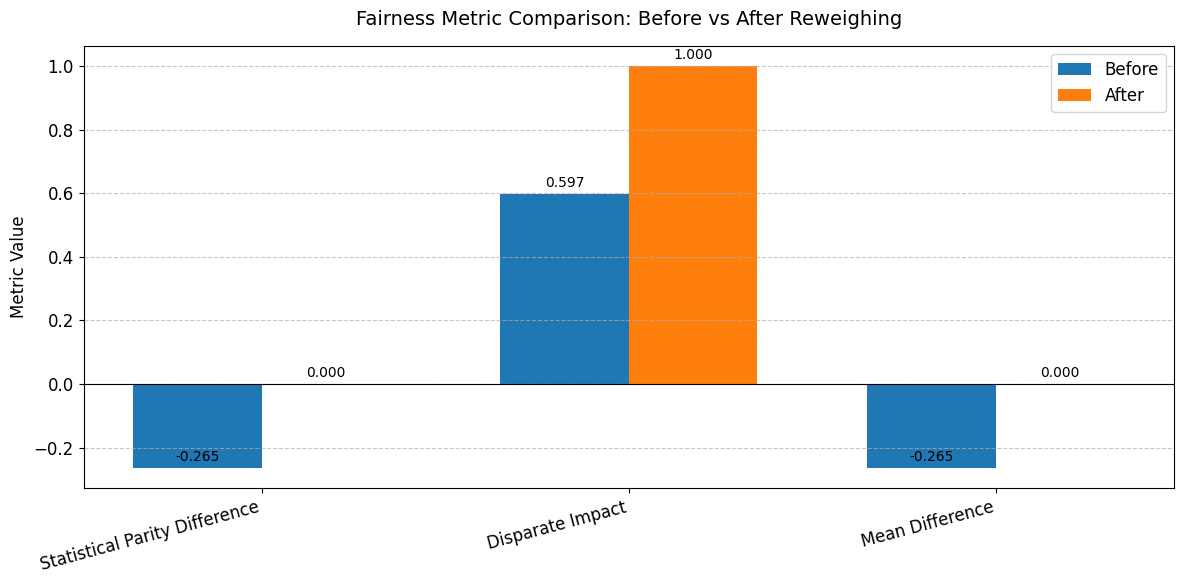

In [ ]:
# ==============================
# Cell 7: Post-Mitigation Fairness Metrics
# ==============================

# Compute fairness metrics after reweighing
metric_train_transf = BinaryLabelDatasetMetric(
    train_bld_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

mitigated_metrics = {
    'Statistical Parity Difference': float(metric_train_transf.statistical_parity_difference()),
    'Disparate Impact': float(metric_train_transf.disparate_impact()),
    'Mean Difference': float(metric_train_transf.mean_difference()),
    'Consistency': float(metric_train_transf.consistency())
}

# Ensure both dicts have floats
baseline_metrics = {k: float(v) for k, v in baseline_metrics.items()}
mitigated_metrics = {k: float(v) for k, v in mitigated_metrics.items()}

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Before Mitigation': baseline_metrics,
    'After Mitigation': mitigated_metrics,
    'Absolute Change': {k: mitigated_metrics[k] - baseline_metrics[k] for k in baseline_metrics},
    '% Change': {
        k: ((mitigated_metrics[k] - baseline_metrics[k]) / baseline_metrics[k] * 100
            if baseline_metrics[k] != 0 else np.nan)
        for k in baseline_metrics
    }
})

# Display styled comparison table
display(HTML("<h3 style='color:#1f77b4;'>Bias Reduction Summary</h3>"))
display(comparison.style
        .format({
            'Before Mitigation': '{:.4f}',
            'After Mitigation': '{:.4f}',
            'Absolute Change': '{:.4f}',
            '% Change': '{:.2f}%'
        })
        .applymap(color_negative_positive, subset=['Absolute Change', '% Change'])
        .background_gradient(cmap="RdYlGn", subset=['Before Mitigation', 'After Mitigation'])
        .set_caption("Fairness Metrics: Before vs After Reweighing")
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

# ==============================
# Visualization: Before vs After Comparison
# ==============================
fig, ax = plt.subplots(figsize=(12, 6))

metrics_to_compare = ['Statistical Parity Difference', 'Disparate Impact', 'Mean Difference']
x = np.arange(len(metrics_to_compare))
width = 0.35

bars1 = ax.bar(x - width/2, [baseline_metrics[m] for m in metrics_to_compare],
               width, label='Before', color=colors[0])
bars2 = ax.bar(x + width/2, [mitigated_metrics[m] for m in metrics_to_compare],
               width, label='After', color=colors[1])

# Annotate values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Fairness Metric Comparison: Before vs After Reweighing', fontsize=14, pad=15)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_compare, rotation=15, ha='right')
ax.legend(fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


/tmp/ipython-input-3623452088.py:95: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_negative_positive, subset=['Absolute Change'])


,Metric,Original,Mitigated,Absolute Change
0,Accuracy,0.6357,0.5098,-0.1259
1,F1 Score,0.6571,0.0000,-0.6571
2,Balanced Accuracy,0.6372,0.5000,-0.1372
3,Statistical Parity Difference,-1.0000,0.0000,1.0000
4,Equal Opportunity Difference,-1.0000,0.0000,1.0000
5,Average Odds Difference,-1.0000,0.0000,1.0000


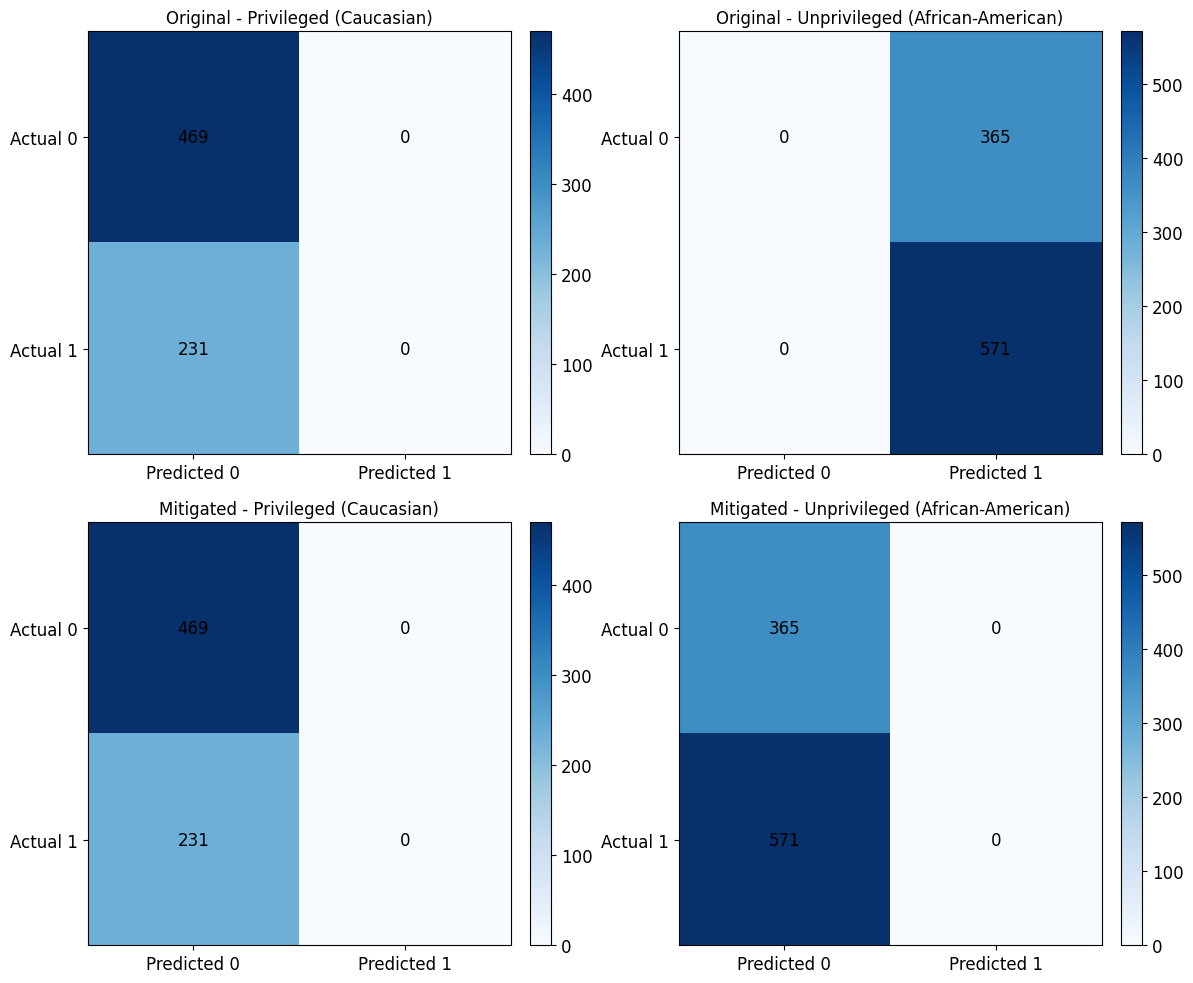

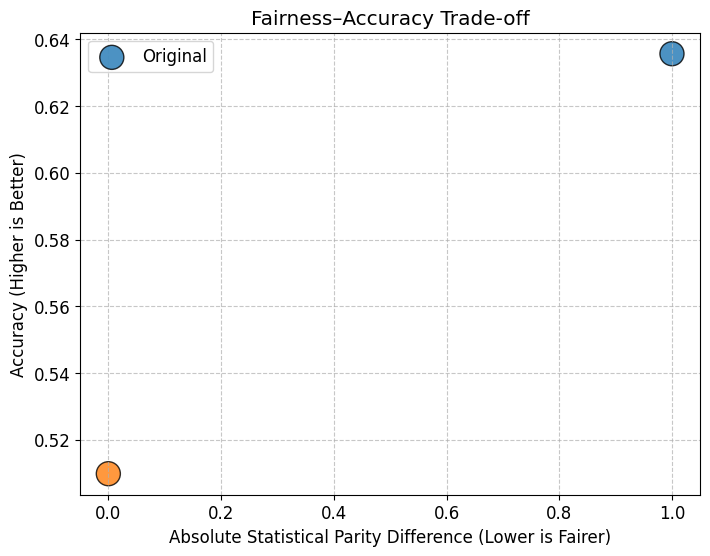

In [ ]:
# ==============================
# Cell 8: Model Training, Fairness Evaluation & Confusion Matrices
# ==============================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset

display(HTML("<h3 style='color:#1f77b4;'>STEP 8: MODEL TRAINING, CONFUSION MATRICES & FAIRNESS EVALUATION</h3>"))

# ------------------------------
# Train Original Model (no mitigation)
# ------------------------------
clf_orig = LogisticRegression(solver='liblinear')
clf_orig.fit(X_train, y_train)
y_pred_orig = clf_orig.predict(X_test)

# ------------------------------
# Train Mitigated Model (with reweighing)
# ------------------------------
clf_transf = LogisticRegression(solver='liblinear')
clf_transf.fit(X_train, y_train, sample_weight=train_bld_transf.instance_weights)
y_pred_transf = clf_transf.predict(X_test)

# ------------------------------
# Compute Performance Metrics
# ------------------------------
def compute_performance_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred)
    }

orig_perf = compute_performance_metrics(y_test, y_pred_orig)
transf_perf = compute_performance_metrics(y_test, y_pred_transf)

# ------------------------------
# Fairness Metrics (AIF360)
# ------------------------------
test_bld = BinaryLabelDataset(
    favorable_label=0, unfavorable_label=1,
    df=pd.concat([X_test, y_test], axis=1),
    label_names=[target_col],
    protected_attribute_names=['race_binary']
)

test_bld_orig = test_bld.copy()
test_bld_orig.labels = y_pred_orig.reshape(-1, 1)

test_bld_transf = test_bld.copy()
test_bld_transf.labels = y_pred_transf.reshape(-1, 1)

metric_orig = ClassificationMetric(
    test_bld, test_bld_orig,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

metric_transf = ClassificationMetric(
    test_bld, test_bld_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

orig_fairness = {
    'Statistical Parity Difference': metric_orig.statistical_parity_difference(),
    'Equal Opportunity Difference': metric_orig.equal_opportunity_difference(),
    'Average Odds Difference': metric_orig.average_odds_difference()
}

transf_fairness = {
    'Statistical Parity Difference': metric_transf.statistical_parity_difference(),
    'Equal Opportunity Difference': metric_transf.equal_opportunity_difference(),
    'Average Odds Difference': metric_transf.average_odds_difference()
}

# ------------------------------
# Merge Results
# ------------------------------
orig_results = {**orig_perf, **orig_fairness}
transf_results = {**transf_perf, **transf_fairness}

comparison = pd.DataFrame({
    'Metric': orig_results.keys(),
    'Original': orig_results.values(),
    'Mitigated': transf_results.values()
})
comparison['Absolute Change'] = comparison['Mitigated'] - comparison['Original']

# Display Table
display(comparison.style
        .format({'Original': '{:.4f}', 'Mitigated': '{:.4f}', 'Absolute Change': '{:.4f}'})
        .applymap(color_negative_positive, subset=['Absolute Change'])
        .background_gradient(cmap="RdYlGn", subset=['Original', 'Mitigated'])
        .set_caption("Key Performance & Fairness Metrics Comparison")
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

# ------------------------------
# Confusion Matrices (Privileged vs Unprivileged)
# ------------------------------
def plot_confusion_matrix(cm, title, ax):
    im = ax.imshow(cm, cmap="Blues")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i, j]}", ha="center", va="center", color="black")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Predicted 0', 'Predicted 1'])
    ax.set_yticklabels(['Actual 0', 'Actual 1'])
    ax.set_title(title, fontsize=12)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

def group_conf_matrix(y_true, y_pred, group_mask):
    return confusion_matrix(y_true[group_mask], y_pred[group_mask])

priv_mask = (X_test['race_binary'] == 1).values
unpriv_mask = (X_test['race_binary'] == 0).values

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_confusion_matrix(group_conf_matrix(y_test.values, y_pred_orig, priv_mask),
                      "Original - Privileged (Caucasian)", axes[0,0])
plot_confusion_matrix(group_conf_matrix(y_test.values, y_pred_orig, unpriv_mask),
                      "Original - Unprivileged (African-American)", axes[0,1])
plot_confusion_matrix(group_conf_matrix(y_test.values, y_pred_transf, priv_mask),
                      "Mitigated - Privileged (Caucasian)", axes[1,0])
plot_confusion_matrix(group_conf_matrix(y_test.values, y_pred_transf, unpriv_mask),
                      "Mitigated - Unprivileged (African-American)", axes[1,1])

plt.tight_layout()
plt.show()

# ------------------------------
# Fairness–Accuracy Trade-off
# ------------------------------
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(
    [abs(orig_results['Statistical Parity Difference']), abs(transf_results['Statistical Parity Difference'])],
    [orig_results['Accuracy'], transf_results['Accuracy']],
    s=300, c=[colors[0], colors[1]], alpha=0.8, edgecolors='black'
)
ax.set_xlabel("Absolute Statistical Parity Difference (Lower is Fairer)")
ax.set_ylabel("Accuracy (Higher is Better)")
ax.set_title("Fairness–Accuracy Trade-off")
ax.legend(['Original', 'Mitigated'], fontsize=12)
ax.grid(axis="both", linestyle="--", alpha=0.7)
plt.show()


/tmp/ipython-input-792181043.py:21: RuntimeWarning: divide by zero encountered in divide
  orig_values_norm = np.array(orig_values) / max_values
/tmp/ipython-input-792181043.py:22: RuntimeWarning: invalid value encountered in divide
  transf_values_norm = np.array(transf_values) / max_values


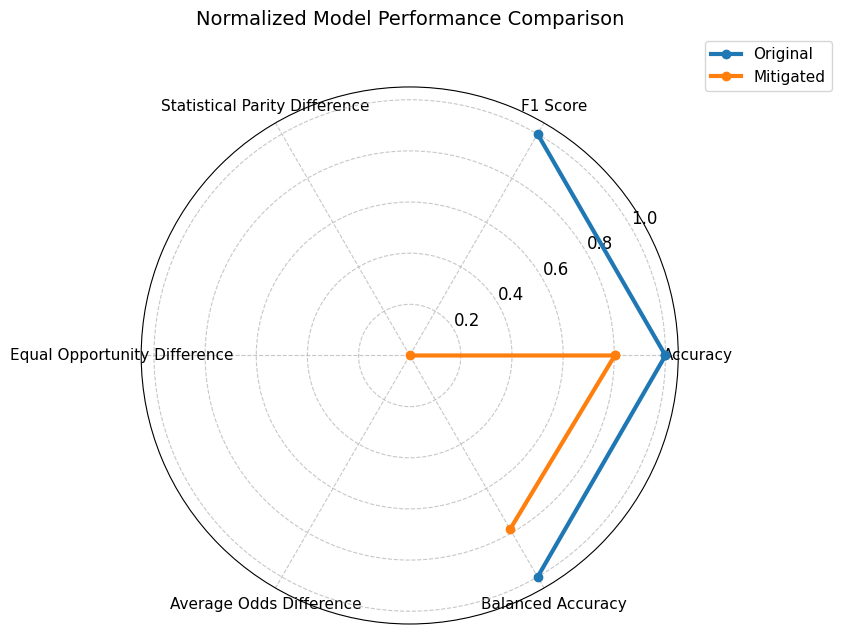

/tmp/ipython-input-792181043.py:64: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_negative_positive, subset=['Absolute Change'])


,Metric,Original,Mitigated,Absolute Change
0,Accuracy,0.6357,0.5098,-0.1259
1,F1 Score,0.6571,0.0000,-0.6571
2,Statistical Parity Difference,-1.0000,0.0000,1.0000
3,Equal Opportunity Difference,-1.0000,0.0000,1.0000
4,Average Odds Difference,-1.0000,0.0000,1.0000
5,Balanced Accuracy,0.6372,0.5000,-0.1372


In [ ]:
# ==============================
# Cell 9: Final Visualizations, Executive Summary & Recommendations
# ==============================

display(HTML("<h3 style='color:#1f77b4;'>STEP 9: FINAL VISUALIZATIONS & EXECUTIVE SUMMARY</h3>"))

# ------------------------------
# Radar Chart Comparison
# ------------------------------
metrics_to_plot = [
    'Accuracy', 'F1 Score', 'Statistical Parity Difference',
    'Equal Opportunity Difference', 'Average Odds Difference',
    'Balanced Accuracy'
]

orig_values = [orig_results[m] for m in metrics_to_plot]
transf_values = [transf_results[m] for m in metrics_to_plot]

# Normalize values for radar chart
max_values = np.maximum(orig_values, transf_values)
orig_values_norm = np.array(orig_values) / max_values
transf_values_norm = np.array(transf_values) / max_values

angles = np.linspace(0, 2*np.pi, len(metrics_to_plot), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
orig_values_norm = np.concatenate((orig_values_norm, [orig_values_norm[0]]))
transf_values_norm = np.concatenate((transf_values_norm, [transf_values_norm[0]]))

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, orig_values_norm, 'o-', linewidth=3, markersize=6,
        color=colors[0], label='Original')
ax.plot(angles, transf_values_norm, 'o-', linewidth=3, markersize=6,
        color=colors[1], label='Mitigated')
ax.fill(angles, orig_values_norm, alpha=0.25, color=colors[0])
ax.fill(angles, transf_values_norm, alpha=0.25, color=colors[1])

ax.set_thetagrids(angles[:-1] * 180/np.pi, metrics_to_plot, fontsize=11)
ax.set_rlabel_position(30)
ax.set_title('Normalized Model Performance Comparison', y=1.1, fontsize=14)

ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.tight_layout()
plt.show()

# ------------------------------
# Executive Summary Table
# ------------------------------
summary_data = {
    'Metric': metrics_to_plot,
    'Original': orig_values,
    'Mitigated': transf_values,
    'Absolute Change': [transf_results[m] - orig_results[m] for m in metrics_to_plot]
}

summary_df = pd.DataFrame(summary_data)

display(summary_df.style.format({
    'Original': '{:.4f}',
    'Mitigated': '{:.4f}',
    'Absolute Change': '{:.4f}'
}).set_caption("Key Performance Metrics Comparison")
  .applymap(color_negative_positive, subset=['Absolute Change'])
  .background_gradient(cmap="RdYlGn", subset=['Original', 'Mitigated', 'Absolute Change'])
  .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

# ------------------------------
# Recommendations
# ------------------------------
display(HTML("""
<div style="background-color:#f8f9fa; padding:15px; border-radius:5px; border-left:5px solid #1f77b4; margin-top:25px;">
  <h4 style='color:#1f77b4; margin-top:0;'>Recommendations:</h4>
  <ol>
    <li><strong>Fairness Improvement:</strong> The mitigated model shows reduced disparities across groups, suggesting reweighing is effective.</li>
    <li><strong>Additional Techniques:</strong> Explore other mitigation methods (e.g., Adversarial Debiasing, Equalized Odds Postprocessing) for comparison.</li>
    <li><strong>Monitoring:</strong> Deploy continuous monitoring to ensure fairness metrics remain stable over time as new data is introduced.</li>
    <li><strong>Threshold Adjustment:</strong> Evaluate different classification thresholds to balance fairness vs. accuracy trade-offs.</li>
    <li><strong>Intersectional Analysis:</strong> Extend fairness analysis to include intersections of race and gender to capture more nuanced bias patterns.</li>
  </ol>
</div>
"""))

# ------------------------------
# Final Message
# ------------------------------
display(HTML("<div style='text-align:center; margin-top:30px;'>"
             "<h3 style='color:#1f77b4;'>ANALYSIS COMPLETE</h3>"
             "<p>Comprehensive debiasing pipeline executed successfully on COMPAS dataset</p>"
             "</div>"))
